In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (156).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (202).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (152).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (215).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (57).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (143).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (58).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (84).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (53).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (147).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (125).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenning/grenning (72).jpg
/kaggle/input/orange-diseases-dataset/dataset/test/grenni

# Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

2024-06-08 15:22:08.107091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 15:22:08.107180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 15:22:08.231459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
directory = '/kaggle/input/orange-diseases-dataset'
input_folder = directory
output_folder = '/kaggle/working/orange'

In [4]:
seed=123
train_dir = '/kaggle/input/orange-diseases-dataset/dataset/train'
test_dir = '/kaggle/input/orange-diseases-dataset/dataset/test'
generator_train = ImageDataGenerator(rescale=1./255, featurewise_center=False, 
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)
#below isv1
#    rescale=1./255, height_shift_range=0.1,
#    horizontal_flip=True, vertical_flip=False)
generator_test = ImageDataGenerator(rescale=1./255, featurewise_center=False, 
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)
#below isv1
#    rescale=1./255, height_shift_range=0.1,
#    horizontal_flip=True, vertical_flip=False)
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset='training',
    seed=seed
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 1164 files belonging to 4 classes.
Using 932 files for training.
Found 626 files belonging to 4 classes.
Using 125 files for validation.


In [5]:
def visualize_images(path, num_images=5):
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    if not image_filenames:
        raise ValueError("No images found in the specified path")
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')
    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = plt.imread(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)
    plt.tight_layout()
    plt.show()

In [6]:
classes = train_ds.class_names

BLACKSPOT


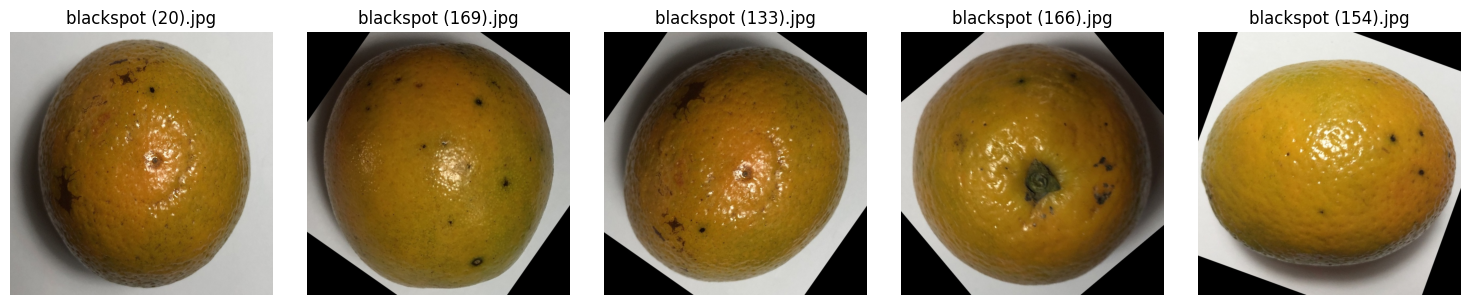

CANKER


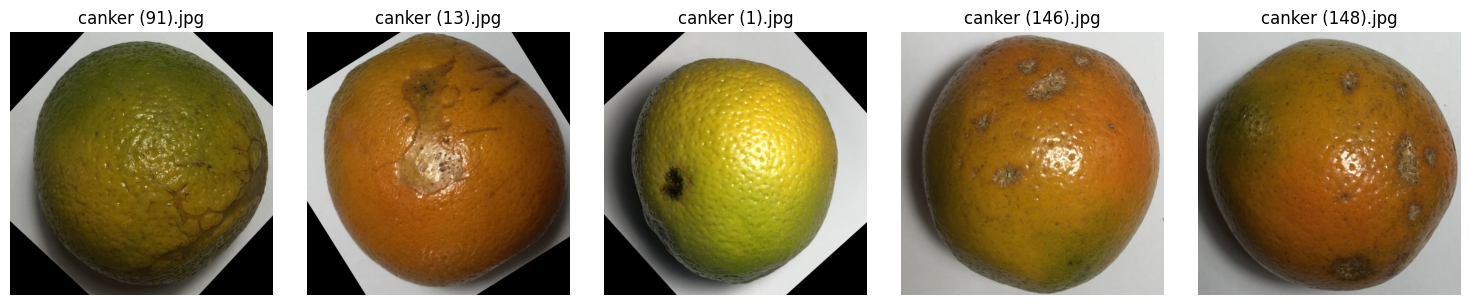

FRESH


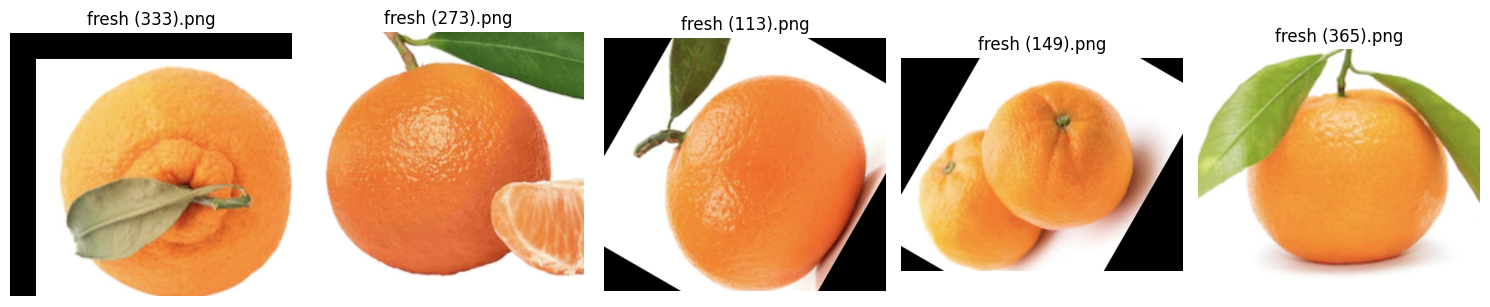

GRENNING


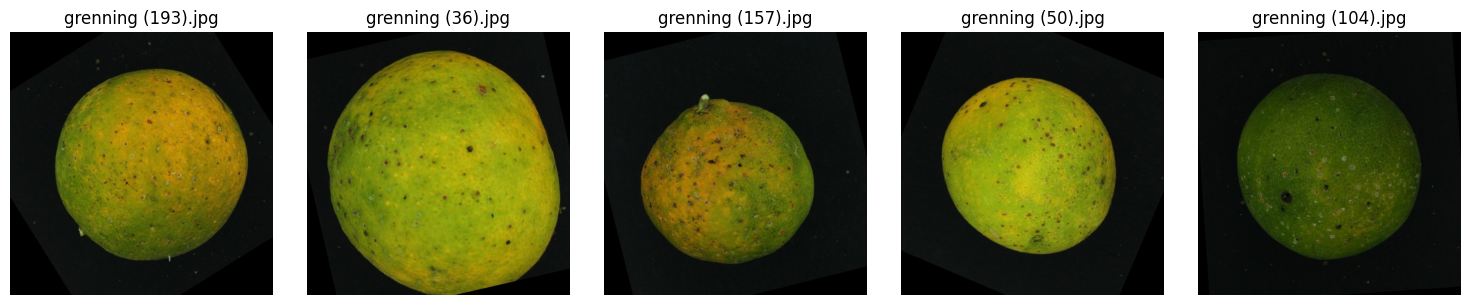

In [7]:
for label in classes:
    path_to_visualize = f"/kaggle/input/orange-diseases-dataset/dataset/train/{label}"
    print(label.upper())
    visualize_images(path_to_visualize, num_images=5)

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs= {}):
        if(logs.get('val_accuracy') > 0.95):
            print("\nTarget reached, stop training process")
            self.model.stop_training = True

In [9]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='softmax')
])
callback = myCallback()
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_ds, batch_size=32, epochs=100, validation_data=validation_ds, verbose=1)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-06-08 15:22:31.574189: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 5.22285, expected 4.50617
2024-06-08 15:22:31.574248: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19: 4.83523, expected 4.11855
2024-06-08 15:22:31.574257: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 6.14347, expected 5.42679
2024-06-08 15:22:31.574265: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21: 5.72417, expected 5.00749
2024-06-08 15:22:31.574273: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 6.00776, expected 5.29109
2024-06-08 15:22:31.574281: E

 3/30 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3160 - loss: 1.5400 

I0000 00:00:1717860159.086179     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4170 - loss: 1.3460

2024-06-08 15:22:42.452424: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129063: 5.35229, expected 4.67255
2024-06-08 15:22:42.452505: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129317: 4.6381, expected 3.95836
2024-06-08 15:22:42.452521: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129442: 5.36458, expected 4.68484
2024-06-08 15:22:42.452535: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129443: 5.7503, expected 5.07056
2024-06-08 15:22:42.452553: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129464: 5.45647, expected 4.77673
2024-06-08 15:22:42.452565: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129486: 5.67042, expected 4.99069
2024-06-08 15:22:42.452576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129487: 5.79308, expected 5.11335
2024-06-08 15:22:42.45

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.4188 - loss: 1.3413

W0000 00:00:1717860166.580759     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-08 15:22:48.131054: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197041: 4.50039, expected 3.93494
2024-06-08 15:22:48.131145: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 207030: 4.50039, expected 3.93494
2024-06-08 15:22:48.131195: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 217021: 4.50039, expected 3.93494
2024-06-08 15:22:48.131242: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 227012: 4.50039, expected 3.93494
2024-06-08 15:22:48.131288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 237001: 4.50039, expected 3.93494
2024-06-08 15:22:48.131364: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 246992: 4.50039, expected 3.93494
2024-06-08 15:22:48.131474: E exter

30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - accuracy: 0.4204 - loss: 1.3370 - val_accuracy: 0.5680 - val_loss: 1.8315
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6187 - loss: 0.8909 - val_accuracy: 0.5840 - val_loss: 1.2750
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6510 - loss: 0.7903 - val_accuracy: 0.7040 - val_loss: 0.6775
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7359 - loss: 0.6623 - val_accuracy: 0.8560 - val_loss: 0.3982
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.7546 - loss: 0.5771 - val_accuracy: 0.8400 - val_loss: 0.3675
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7988 - loss: 0.4920 - val_accuracy: 0.8240 - val_loss: 0.3513
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7699 - loss: 0.5046 - val_accuracy: 0.8480 - val_loss: 0.3363
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8117 - loss: 0.4422 - val_accuracy: 0.8240 - val

In [10]:
print('MODEL ACCURACY = {}%'.format(hist.history["accuracy"][-1]*100))
print('VALIDATION ACCURACY = {}%'.format(hist.history["val_accuracy"][-1]*100))

MODEL ACCURACY = 92.48927235603333%
VALIDATION ACCURACY = 96.79999947547913%


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,542,766 (360.65 MB)

 Trainable params: 31,514,148 (120.22 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 63,028,298 (240.43 MB)

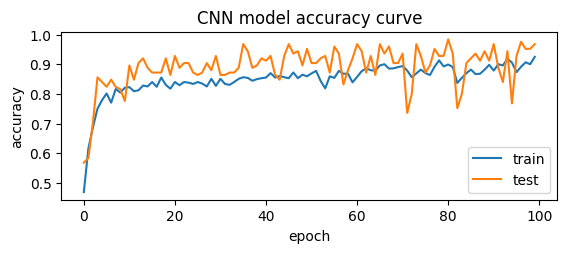

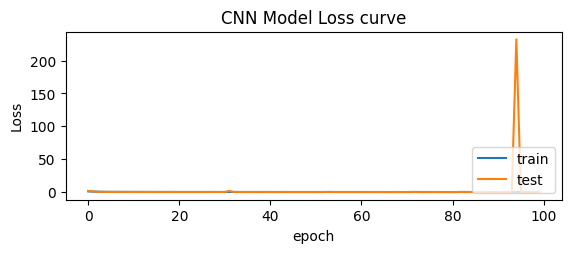

In [12]:
plt.subplot(2,1,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('CNN model accuracy curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CNN Model Loss curve')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [13]:
model.save('orange_fruitdisease_prediction_model.h5')

In [14]:
loaded_model = tf.keras.models.load_model('orange_fruitdisease_prediction_model.h5')